In [1]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter
import sklearn
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tensorflow.keras.datasets import mnist

# Set Device and Random State
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
print(device)
torch.manual_seed(189898)

mps


In [2]:
import ssl
class MnistDigitsM:
    def __init__(self, n_samples=5000, perc_mask=0.1):
        ssl._create_default_https_context = ssl._create_unverified_context
        (train_images, Y_train), (test_images, Y_test) = mnist.load_data()
        train_images = train_images[:n_samples]
        inputs = train_images.reshape((n_samples, 784))/255.0
        inputs = inputs[:n_samples]
        self.labels = Y_train[:n_samples]
        self.true_data = inputs.copy()
        inputs_flat = inputs.ravel()
        ind = np.arange(len(inputs_flat))
        ind_mask = np.random.choice(ind, int(ind.shape[0] * perc_mask))
        inputs_flat[ind_mask] = np.nan
        # mask perc_mask of data
        self.data_train = inputs
        self.test_ind = np.where(np.isnan(inputs))

In [3]:
data = MnistDigitsM(perc_mask=0.9)

In [4]:
data.data_train

array([[ 0.,  0.,  0., ...,  0., nan, nan],
       [nan, nan, nan, ...,  0., nan, nan],
       [ 0.,  0.,  0., ...,  0., nan, nan],
       ...,
       [nan, nan,  0., ..., nan,  0., nan],
       [nan, nan, nan, ...,  0., nan,  0.],
       [nan,  0., nan, ...,  0., nan, nan]])

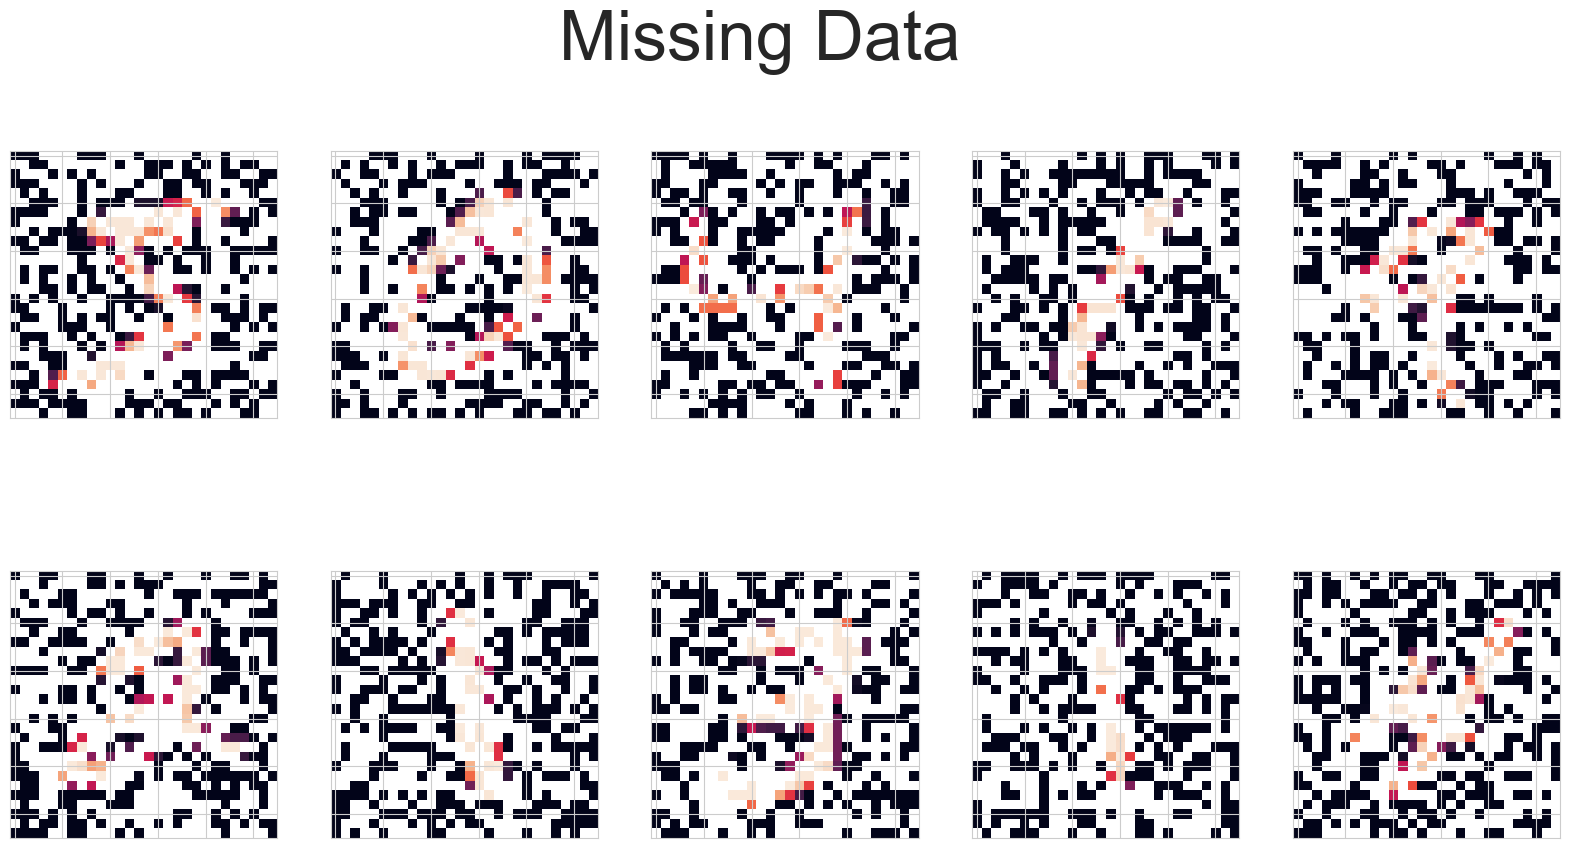

In [5]:
# Function to Plot Images
def plot_images(images, img_prow, width, length, title=None):
    rows = np.ceil(len(images)/img_prow).astype(int)
    fig, (a1) = plt.subplots(rows, img_prow, figsize=(20,10))
    fig.suptitle(title, size=50)
    images = images.reshape(len(images), width, length)
    row_ind = 0
    col_ind = 0
    
    for k in range(len(images)):
        a1[row_ind, col_ind].imshow(images[k,:,:])
        a1[row_ind, col_ind].set_xticklabels([])
        a1[row_ind, col_ind].set_yticklabels([])
        col_ind += 1
        if col_ind > img_prow - 1:
            col_ind = 0
            row_ind += 1
    plt.show()
plot_images(data.data_train[:10], 5, 28, 28, title="Missing Data")

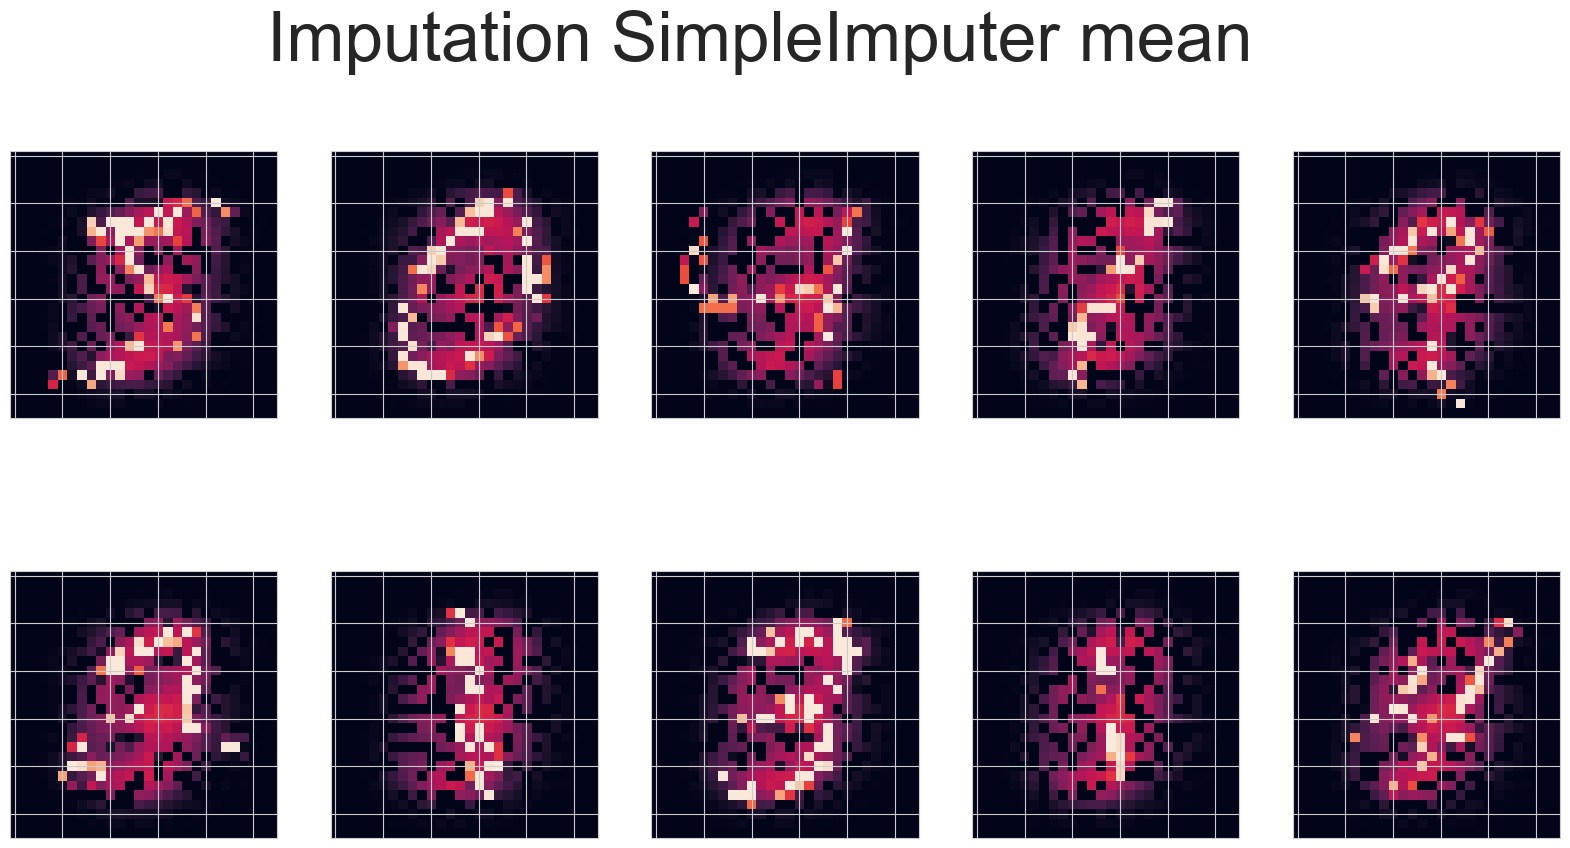

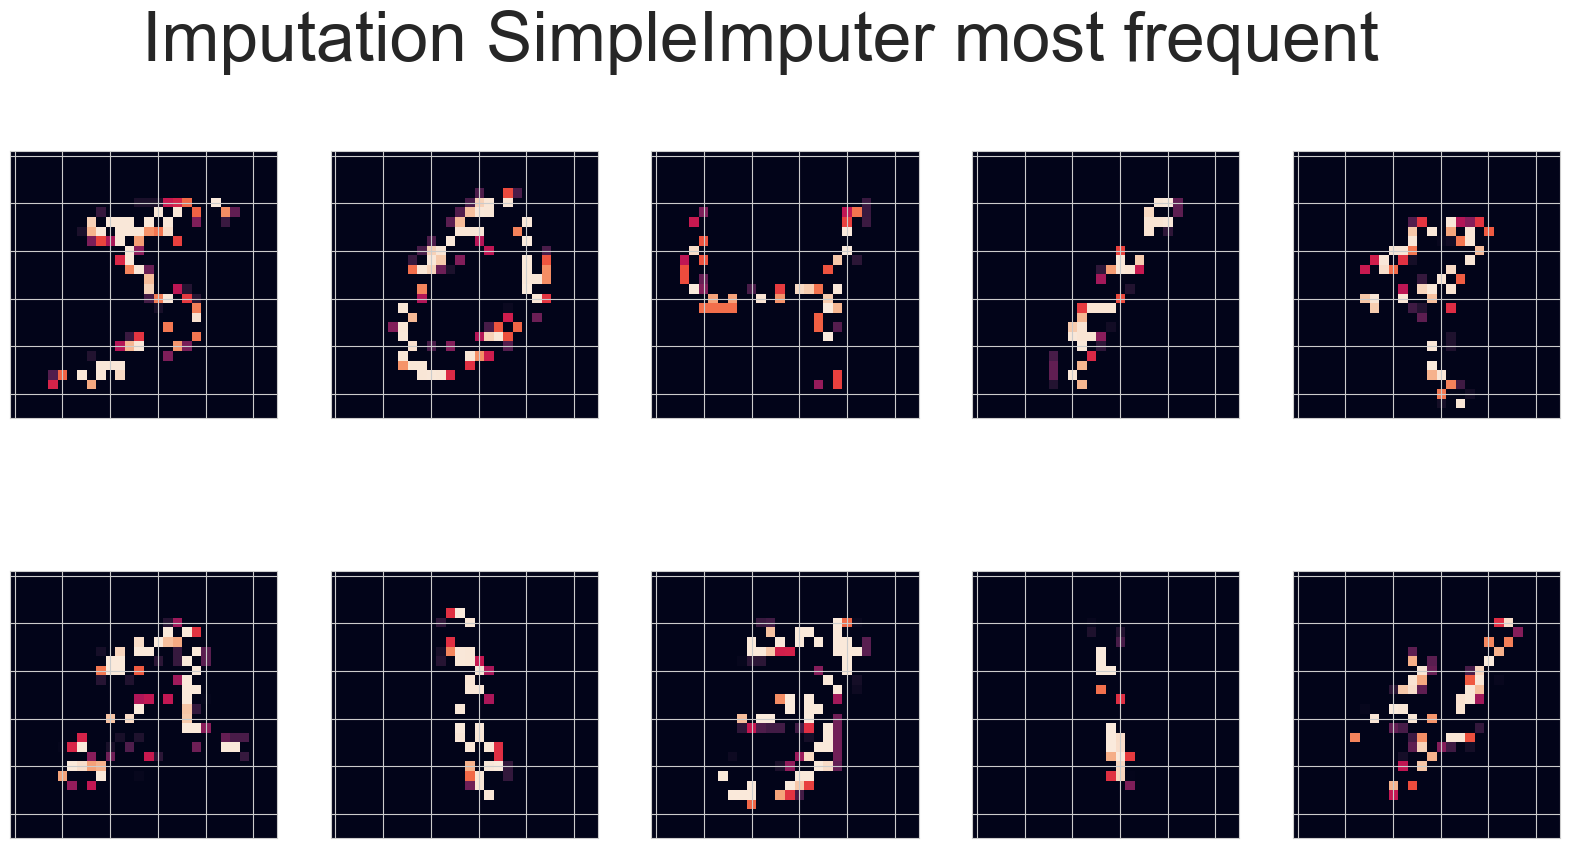

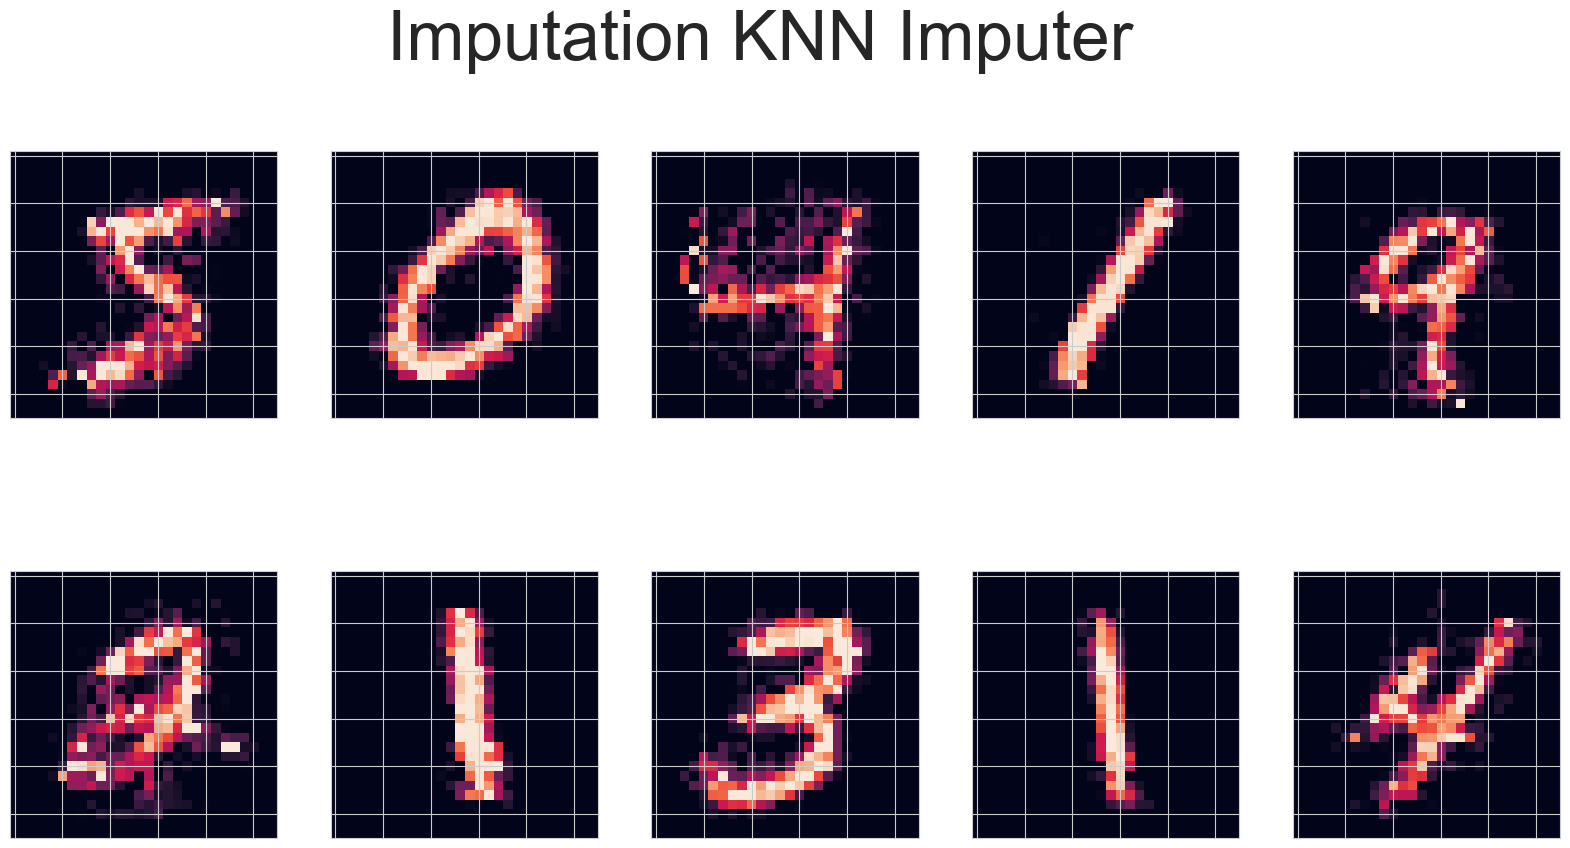

In [6]:
# Machine Learning Methods
from sklearn.impute import SimpleImputer, KNNImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
rec = imp.fit_transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation SimpleImputer mean")

imp = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
rec = imp.fit_transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation SimpleImputer most frequent")


rec = KNNImputer(n_neighbors=10, weights="uniform").fit_transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation KNN Imputer")

In [7]:
# Dataset Class With Mask
class dataset(Dataset):
        def __init__(self, X, mask):
            self.X = X
            self.mask = mask
        def __len__(self):
            return len(self.X)   
        def __getitem__(self, idx):
            return self.X[idx], self.mask[idx]

In [11]:
# Create the Model Architecture
class AE_module(nn.Module):
    def __init__(self, input_dim, hidden_dims, z_dim):
        super().__init__()
        '''
        *** complete the init method and the forward pass ***
        The input_dim is the number of features of your data
        hidden_dim is a list containing the inner layers dimensions as specified above
        z_dim is the dimension of the bottleneck
        '''
        if len(hidden_dims) == 2:
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, hidden_dims[0]),
                nn.ReLU(),
                nn.Linear(hidden_dims[0], hidden_dims[1]),
                nn.ReLU(),
                nn.Linear(hidden_dims[1], z_dim),
                nn.ReLU(),
            )
            self.decoder = nn.Sequential(
                nn.Linear(z_dim, hidden_dims[1]),
                nn.ReLU(),
                nn.Linear(hidden_dims[1], hidden_dims[0]),
                nn.ReLU(),
                nn.Linear(hidden_dims[0], input_dim),
                nn.Sigmoid()
            )
        elif len(hidden_dims) == 3:
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, hidden_dims[0]),
                nn.ReLU(),
                nn.Linear(hidden_dims[0], hidden_dims[1]),
                nn.ReLU(),
                nn.Linear(hidden_dims[1], hidden_dims[2]),
                nn.ReLU(),
                nn.Linear(hidden_dims[2], z_dim),
                nn.ReLU()
            )
            self.decoder = nn.Sequential(
                nn.Linear(z_dim, hidden_dims[2]),
                nn.ReLU(),
                nn.Linear(hidden_dims[2], hidden_dims[1]),
                nn.ReLU(),
                nn.Linear(hidden_dims[1], hidden_dims[0]),
                nn.ReLU(),
                nn.Linear(hidden_dims[0], input_dim),
                nn.Sigmoid()
            )
    
    def forward(self, x):
        '''
        Implement the forward pass
        :param x: the input image
        :return x: the decoded matrix  
        '''
        x = x.view(x.size(0), -1) # Flatten for Linear Layers
        x = self.encoder(x)
        x = self.decoder(x)
        #x = x.view(-1, 1, 28, 28) # Return to Image Dimensions
        return x

In [12]:
class AE_MI():
    """Autoencoder for Matrix Imputation"""
    def __init__(self,  lr=1e-3, 
                 epochs=1000, 
                 batch_size=128, 
                 weight_decay=0,
                 hidden_dims=[300, 200, 100], 
                 z_size = 50):
        
        # Initialize variables
        self.mask = None
        self.loss = None
        self.torch_module = None
        self.optimizer = None
        self.loader = None
        
        # The learning rate for the optimizer 
        self.lr = lr
        
        # number of epochs and batch size
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # dimension of the hidden layers and bottleneck
        self.hidden_dims = hidden_dims  
        self.z_size  = z_size   

        '''***define the reconstruction criterion***'''
        self.criterion = nn.BCELoss()

        self.device = device

    def fit(self, X):
        X = torch.Tensor(X)
        
        # Find zero values to mask to compute the loss
        indices = torch.where(~torch.isnan(X))
        mask_m = torch.zeros(X.shape)
        mask_m[indices[0], indices[1]] = 1
        self.mask = mask_m
        X = torch.nan_to_num_(X)
        
        input_size = X.shape[1]
      
        # Call the AE_module implemented above 
        self.torch_module = AE_module(input_dim=input_size,
                                    hidden_dims=self.hidden_dims,
                                    z_dim=self.z_size)
   
        # define optimizer
        self.optimizer = torch.optim.Adam(self.torch_module.parameters(),
                                          lr=self.lr,
                                          weight_decay=self.weight_decay)
        # Train AE
        self.torch_module.to(self.device)
        self.torch_module.train()
        
        # The dataset class is built with the mask matrix and the data matrix X. 
        data_set = dataset(X, self.mask)
        
        # Dataloader 
        self.loader = torch.utils.data.DataLoader(data_set, batch_size=self.batch_size, shuffle=False)
        
        for epoch in range(self.epochs):
            for batch in self.loader:
                self.optimizer.zero_grad()
                self.train_body(batch)
                self.optimizer.step()
            if epoch % 100 == 0:
                # Just to print the loss and visualize the reconstruction 
                print(f"Epoch {epoch} out of {self.epochs} ==== Loss: {self.loss.item()}")
                rec = model.transform(data.data_train)
                plot_images(rec[:10], 5, 28, 28, title = f"Imputation AE after {epoch} epochs")
                

    def train_body(self, batch):
        data, mask = batch
        mask = mask.to(self.device)
        data = data.to(self.device) 
        x_hat = self.torch_module(data)
        self.apply_loss(data, x_hat, mask)

    def apply_loss(self, x, x_hat, mask):
        x_mask = x * mask
        x_hat_mask = x_hat * mask
        self.loss = self.criterion(x_mask, x_hat_mask)
        self.loss.backward()
    
    def transform(self, X):
        self.torch_module.eval()
        X = torch.Tensor(np.array(X)).to(self.device)
        X = torch.nan_to_num_(X)
        x_rec = self.torch_module(X)
        self.torch_module.train()
        return x_rec.detach().cpu().numpy()

Epoch 0 out of 1000 ==== Loss: nan


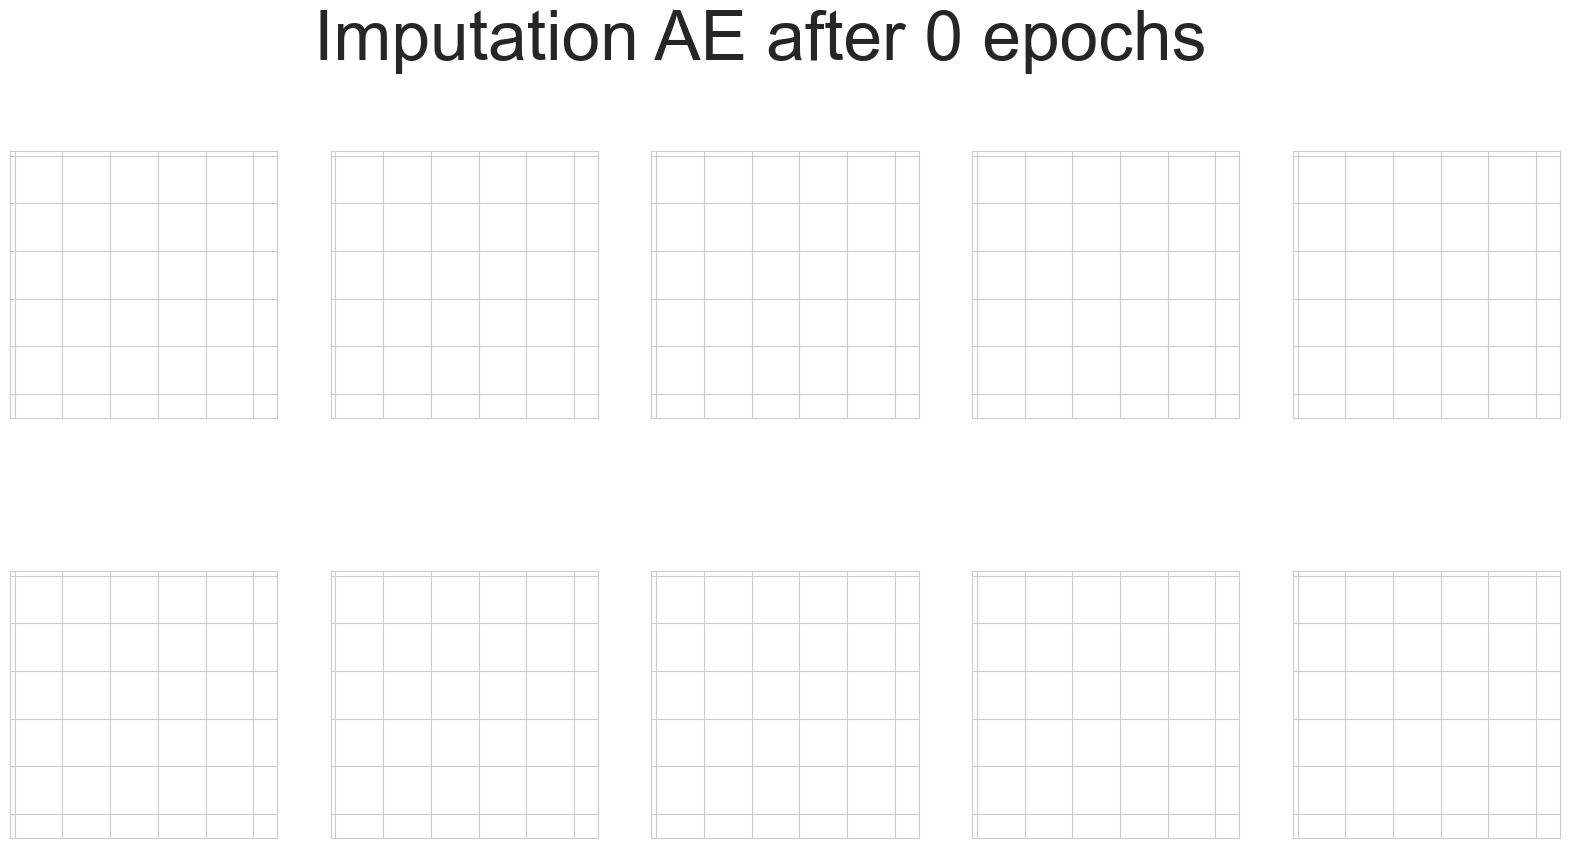

Epoch 100 out of 1000 ==== Loss: nan


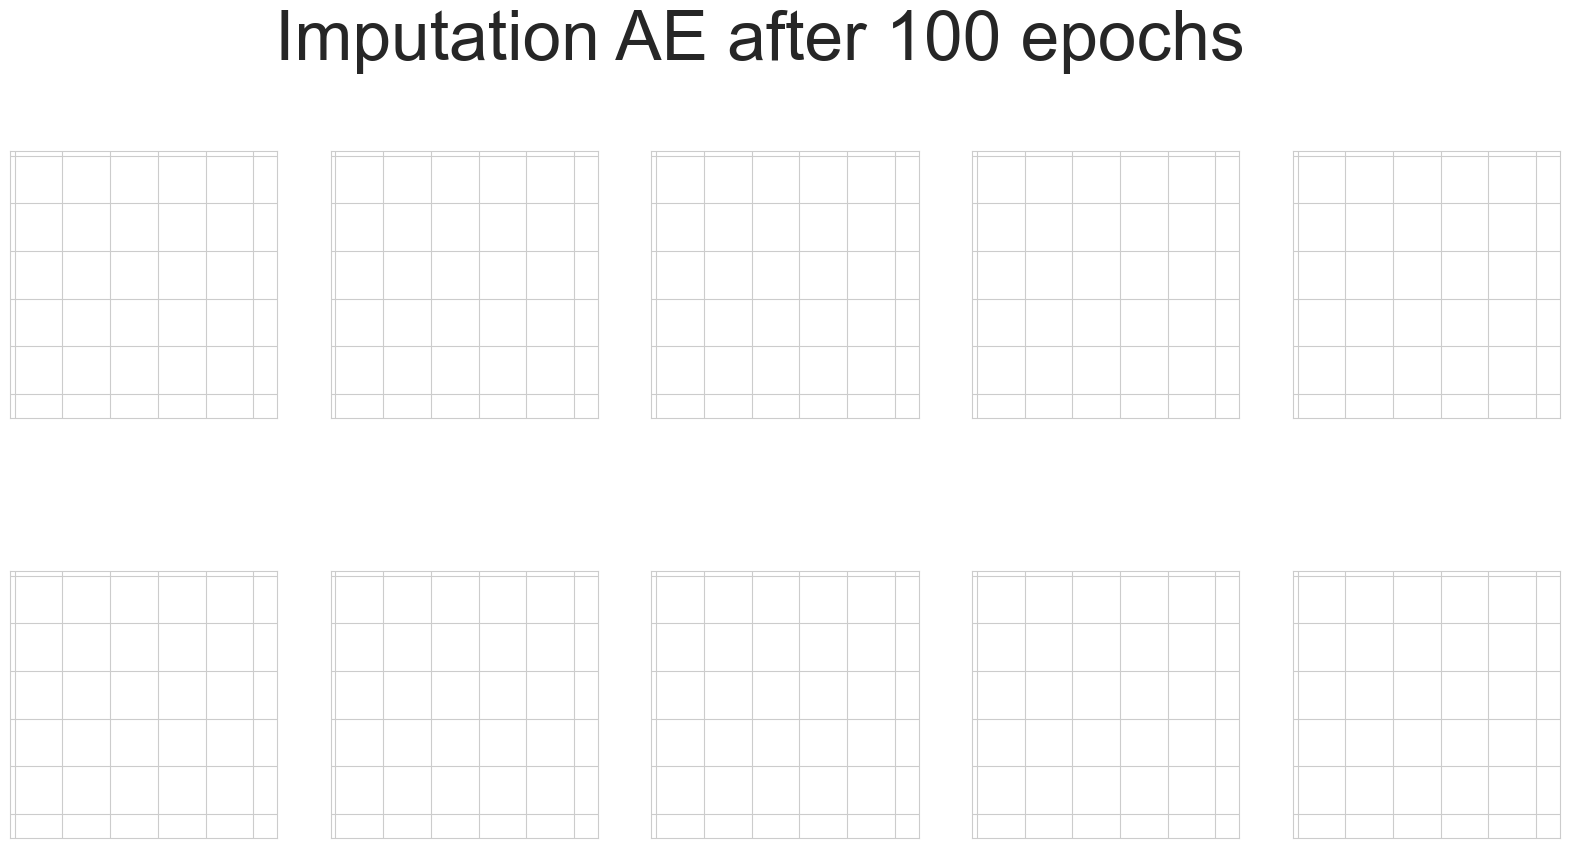

Epoch 200 out of 1000 ==== Loss: nan


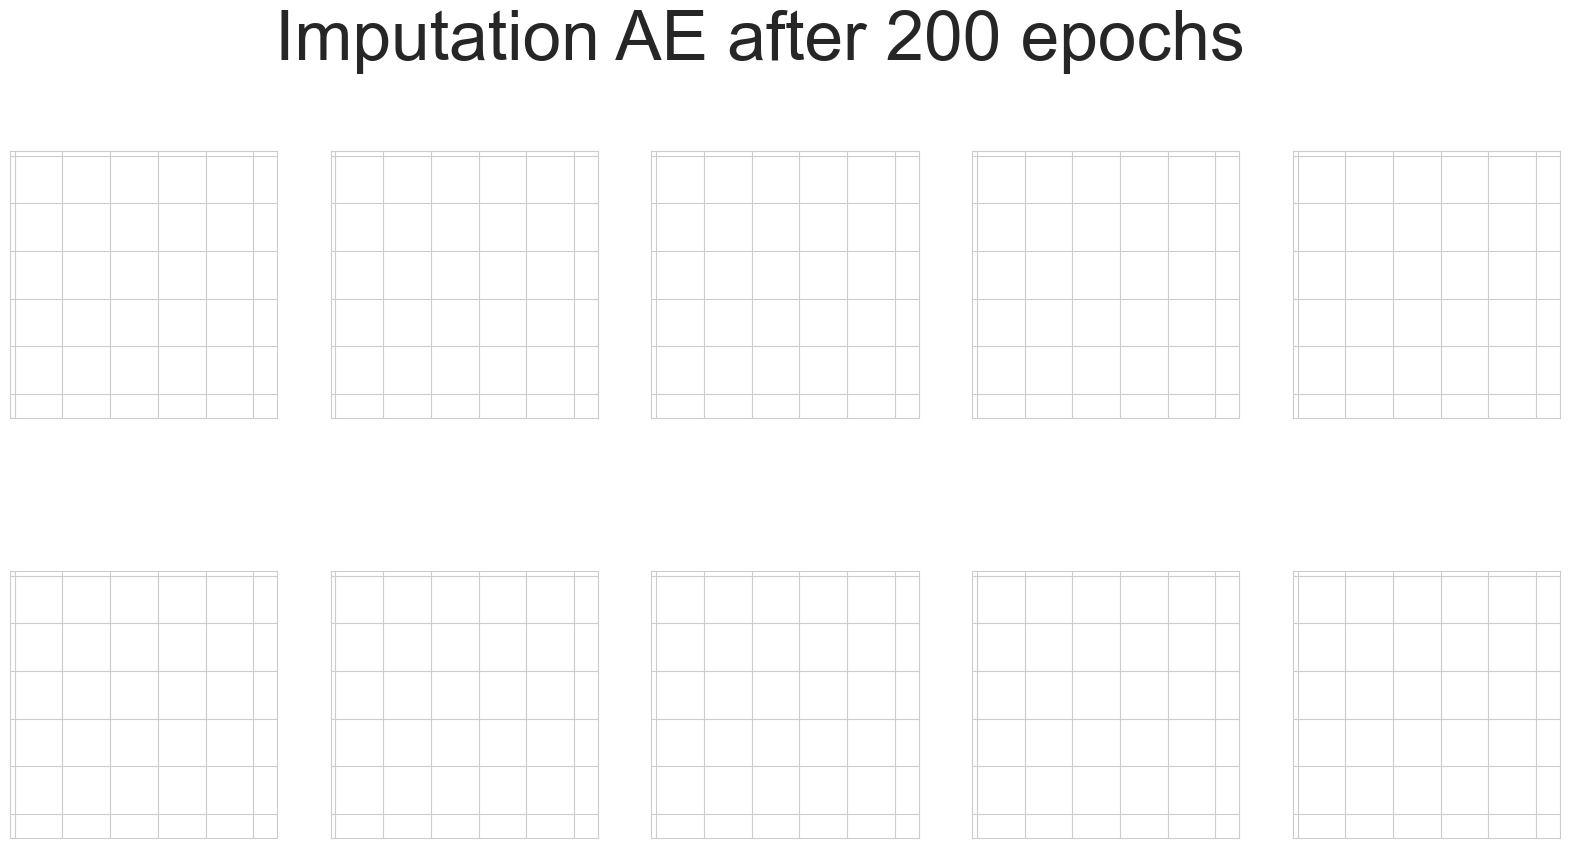

Epoch 300 out of 1000 ==== Loss: nan


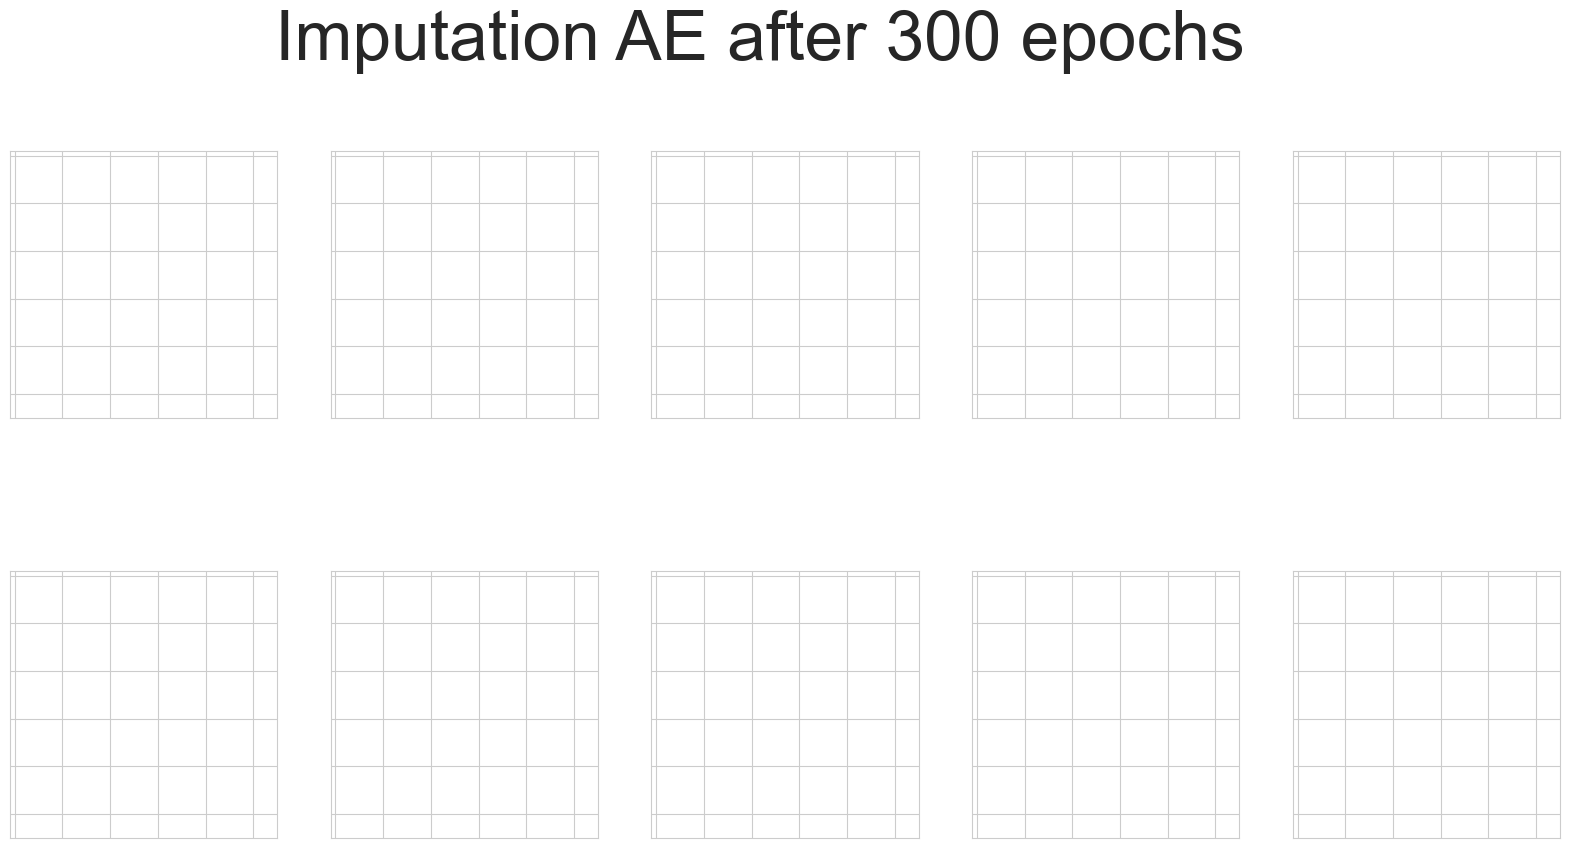

Epoch 400 out of 1000 ==== Loss: nan


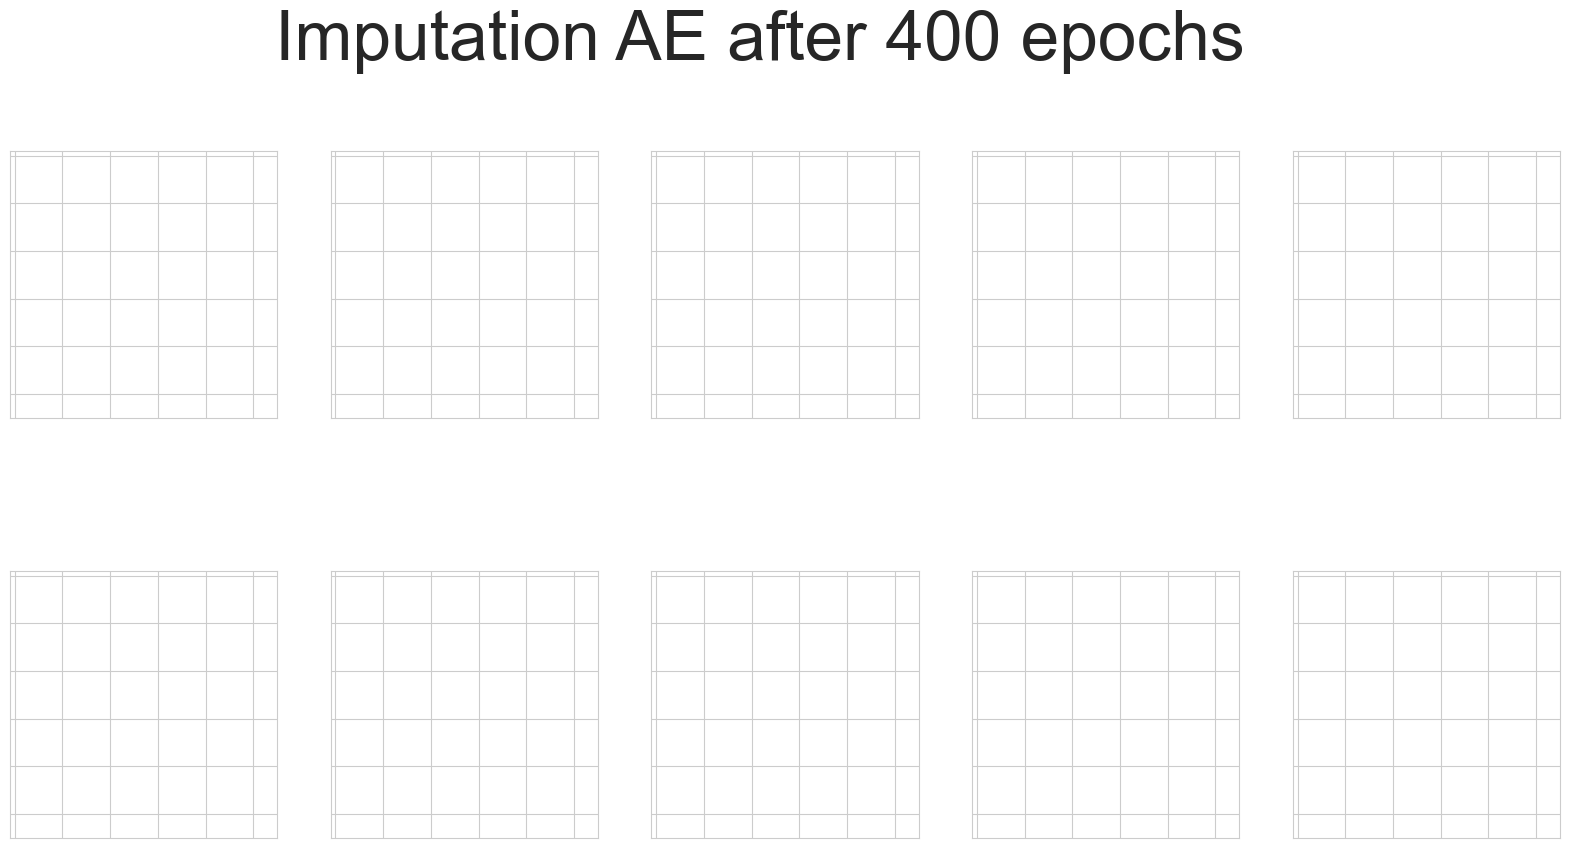

Epoch 500 out of 1000 ==== Loss: nan


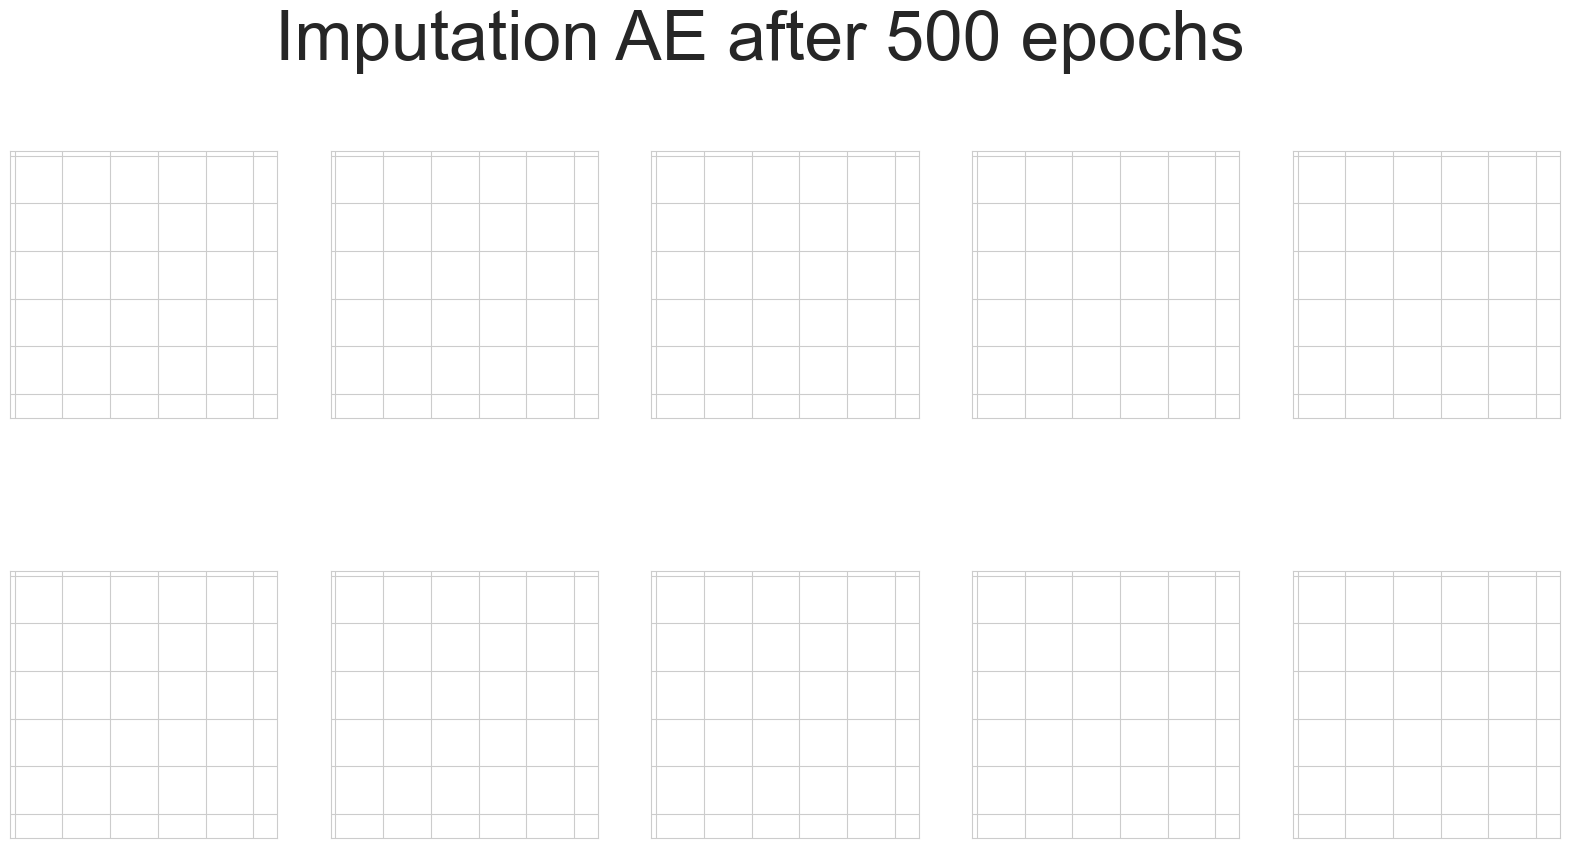

Epoch 600 out of 1000 ==== Loss: nan


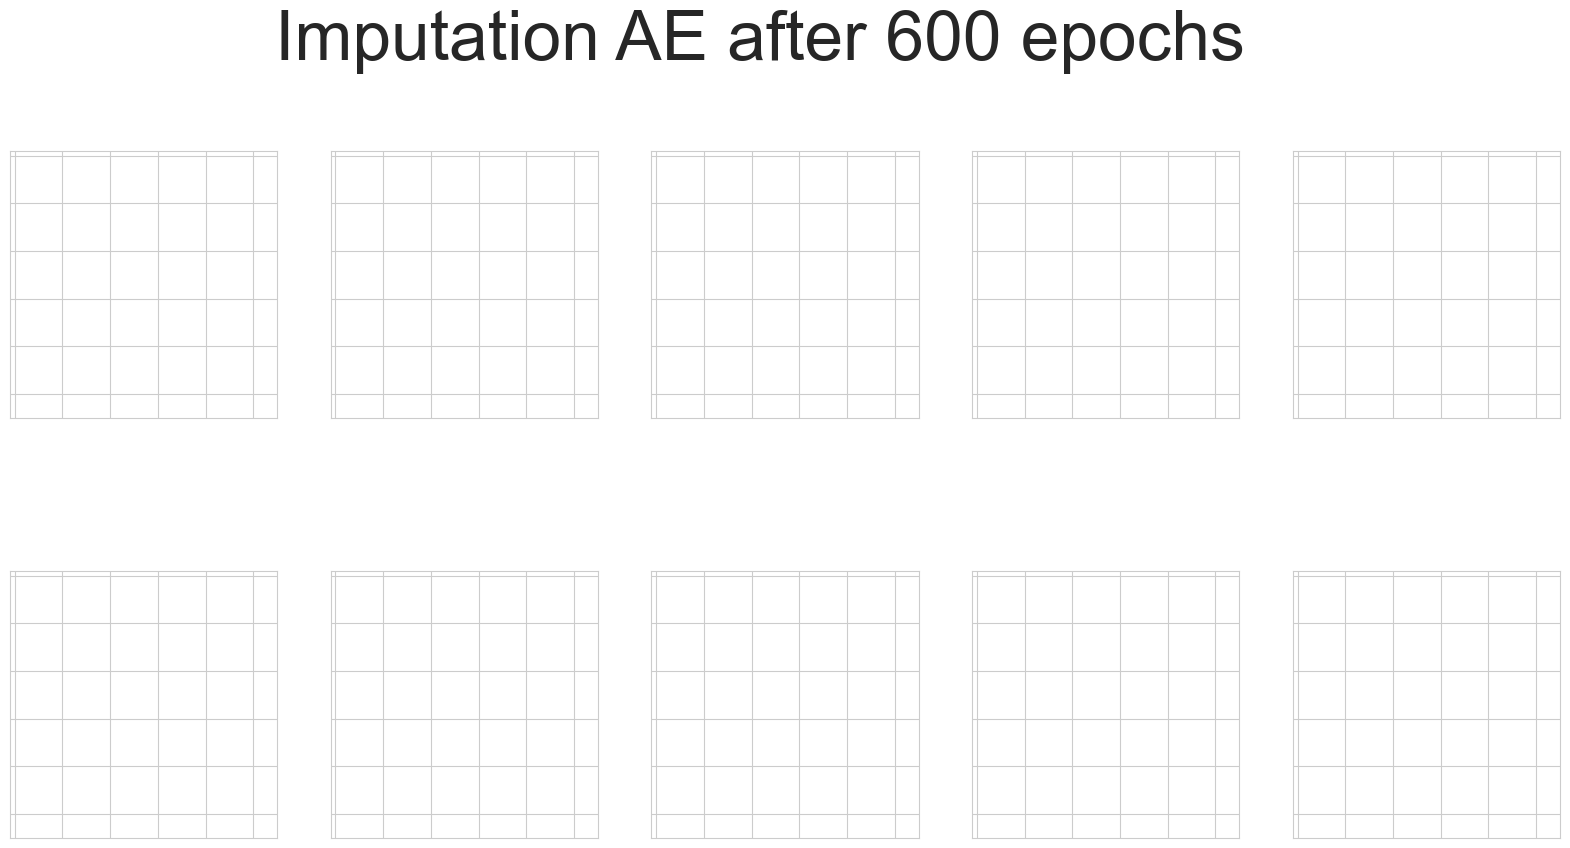

Epoch 700 out of 1000 ==== Loss: nan


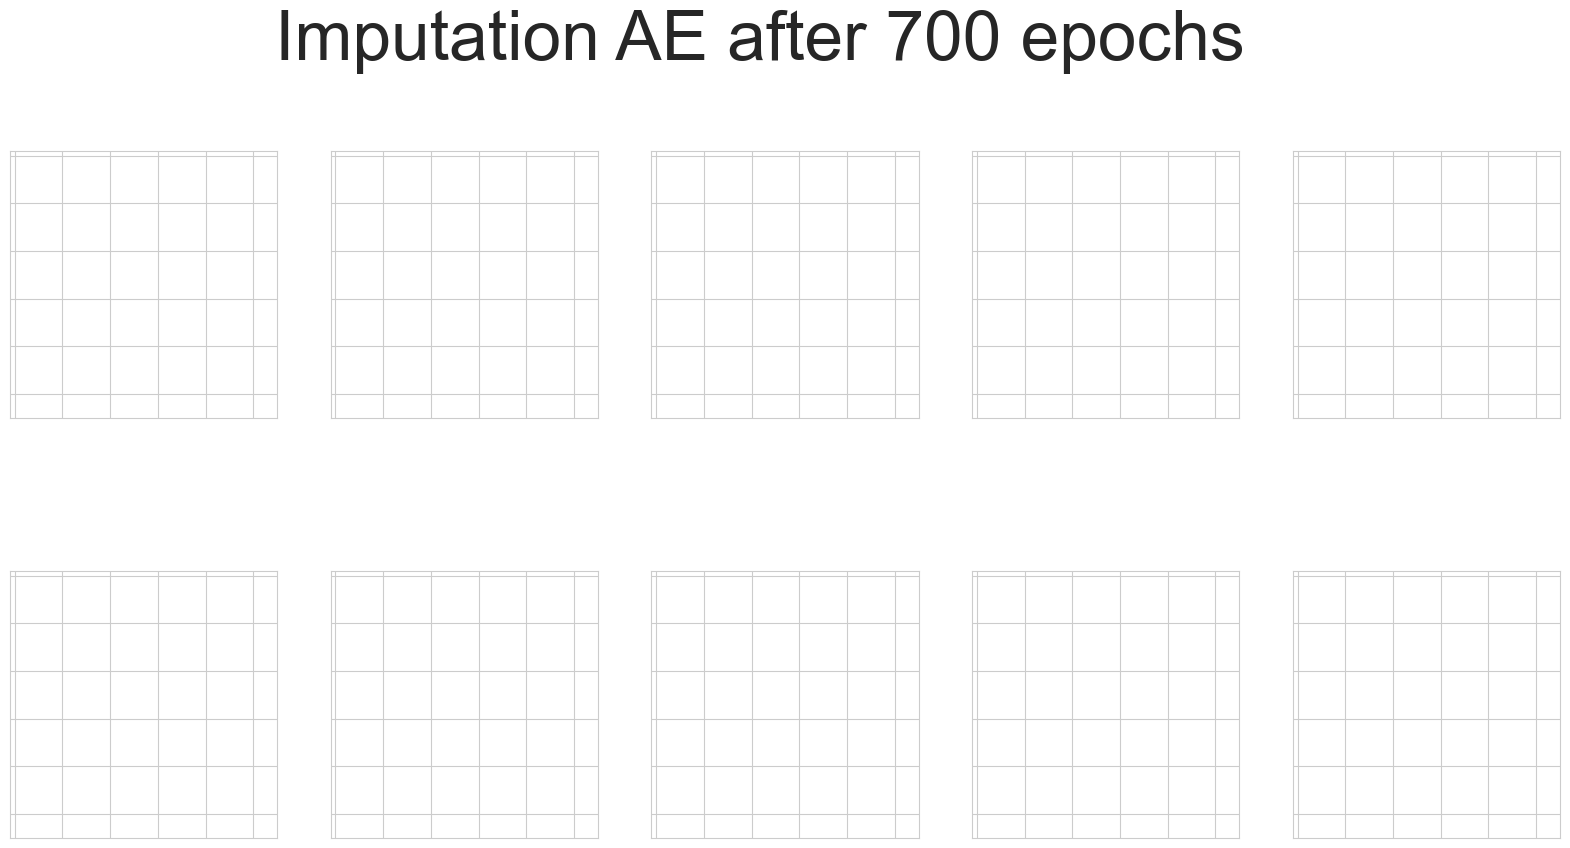

Epoch 800 out of 1000 ==== Loss: nan


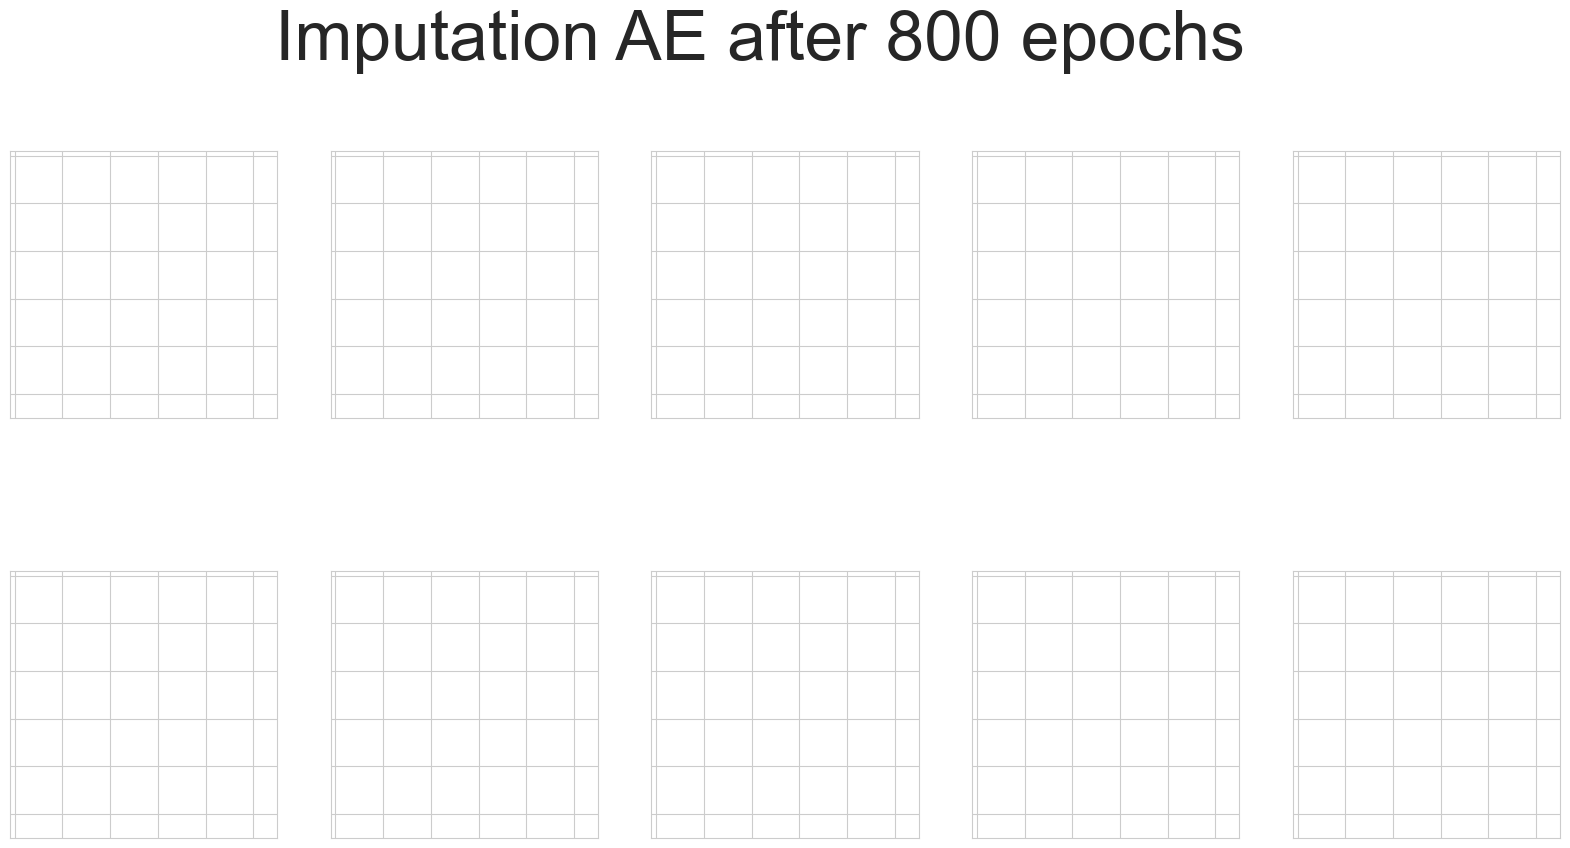

Epoch 900 out of 1000 ==== Loss: nan


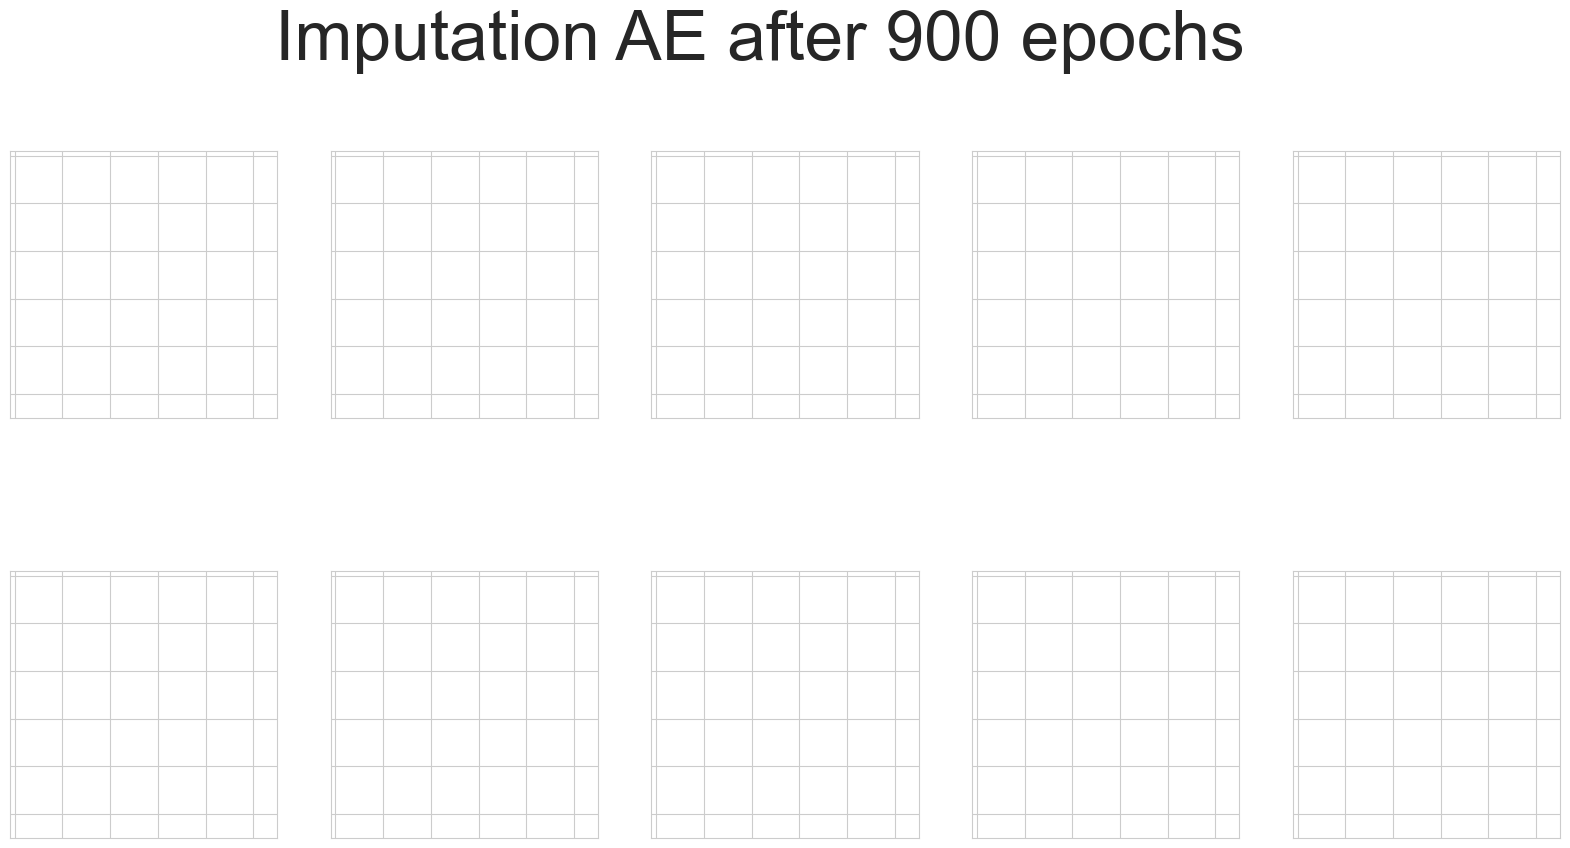

In [13]:
# Create and Fit the Model
model = AE_MI(epochs=1000, z_size=100, hidden_dims=[200, 100])
model.fit(data.data_train)

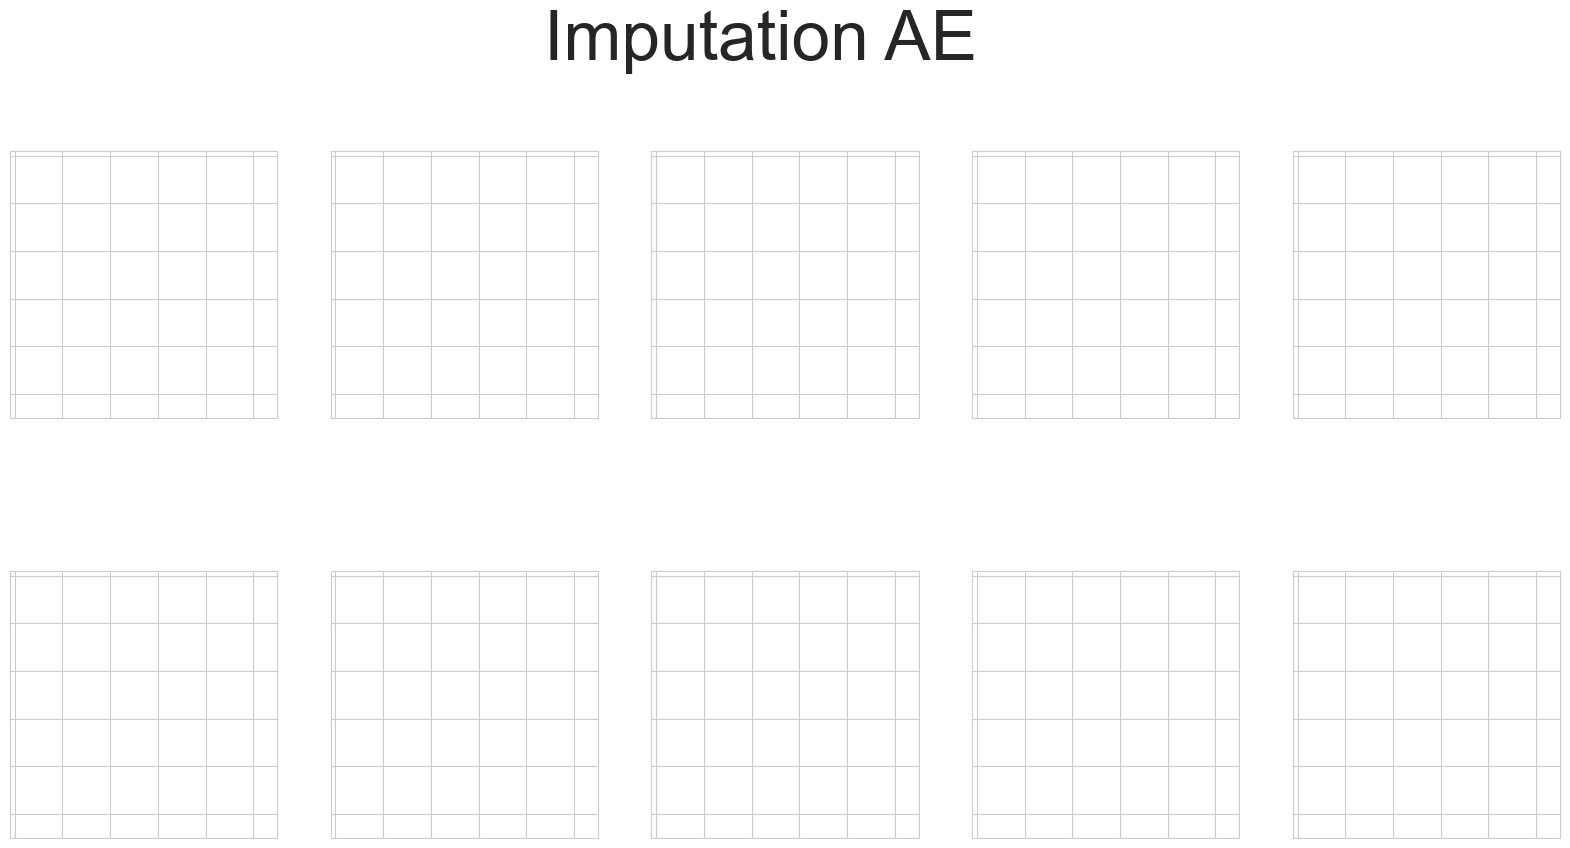

In [14]:
# Transform and Plot
rec = model.transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title="Imputation AE")

In [15]:
'''
*** Compute the MSE of the reconstruction using data.true_data and the output of the 3 sklearn methods and your AE
'''
reconstruction_criterion = nn.MSELoss()
loss = reconstruction_criterion(rec, data.true_data)
print(loss.item())

TypeError: 'int' object is not callable